<a href="https://colab.research.google.com/github/vneumannufprbr/Series-Temporales/blob/main/PredicDemancLTSMDatosBrutosEspa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Importações
import tensorflow as tf
tf.__version__
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# incluido por VN
# correlograma e sazonalidade para determinar tamanho da janela (window size)
import statsmodels.api as sm
# Livraria para preprocessamento
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import FunctionTransformer
from scipy.stats import iqr
# Livaria para autoajuste de parâmetros
!pip install keras-tuner
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
# Livaria pandas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.core import window
from pandas.core import indexes


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.2 MB/s eta 0:00:00


/tmp/ipython-input-3-1791759244.py:23: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [4]:
# Carga da base
#df = pd.read_csv("/content/drive/Othercomputers/Meu computador/Google Drive/Especialização IA UFPR/AAA-Curso IA UFPR/Arquitetura de Dados/Artigos de AI aplicada a Sistemas de Energia/ENCONTRO 02/archive/energy_dataset.csv",  low_memory=False) # dtype=dtype_dict,
#!git clone https://github.com/vneumannufprbr/TrabajosRStudio.git # Dataset con 3.000 instancias
#df = pd.read_csv('TrabajosRStudio/energy_dataset.csv',  low_memory=False) # Dataset con 3.000 instancias # dtype=dtype_dict,
!git clone https://github.com/vneumannufprbr/Series-Temporales.git # Dataset con 35.000 instancias
df = pd.read_csv('Series-Temporales/energy_dataset.csv',  low_memory=False) # Dataset con 35.000 instancias # dtype=dtype_dict,dtype_dict = {
dtype_dict = {
    'time': str,
    'generation biomass': float,
    'generation fossil brown coal/lignite': float,
    'generation fossil gas': float,
    'generation fossil hard coal': float,
    'generation fossil oil': float,
    'generation hydro pumped storage consumption': float,
    'generation hydro run-of-river and poundage': float,
    'generation hydro water reservoir': float,
    'generation nuclear': float,
    'generation solar': float,
    'generation waste': float,
    'generation wind onshore': float,
    'forecast solar day ahead': float,
    'forecast wind onshore day ahead': float,
    'total load forecast': float,
    'total load actual': float,
    'price day ahead': float,
     # ... especificar outros tipos de dados das colunas aqui
    'price actual': float
}
print(df.dtypes)
df

Cloning into 'Series-Temporales'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (6/6), 1.70 MiB | 12.83 MiB/s, done.
time                                            object
generation biomass                             float64
generation fossil brown coal/lignite           float64
generation fossil coal-derived gas             float64
generation fossil gas                          float64
generation fossil hard coal                    float64
generation fossil oil                          float64
generation fossil oil shale                    float64
generation fossil peat                         float64
generation geothermal                          float64
generation hydro pumped storage aggregated     float64
generation hydro pumped storage consumption    float64
generation hydro run-of-river and poundage  

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,2018-12-31 19:00:00+01:00,297.0,0.0,0.0,7634.0,2628.0,178.0,0.0,0.0,0.0,...,277.0,0.0,3113.0,96.0,NaN,3253.0,30619.0,30653.0,68.85,77.02
35060,2018-12-31 20:00:00+01:00,296.0,0.0,0.0,7241.0,2566.0,174.0,0.0,0.0,0.0,...,280.0,0.0,3288.0,51.0,NaN,3353.0,29932.0,29735.0,68.40,76.16
35061,2018-12-31 21:00:00+01:00,292.0,0.0,0.0,7025.0,2422.0,168.0,0.0,0.0,0.0,...,286.0,0.0,3503.0,36.0,NaN,3404.0,27903.0,28071.0,66.88,74.30
35062,2018-12-31 22:00:00+01:00,293.0,0.0,0.0,6562.0,2293.0,163.0,0.0,0.0,0.0,...,287.0,0.0,3586.0,29.0,NaN,3273.0,25450.0,25801.0,63.93,69.89


In [5]:
df.index = pd.to_datetime(df['time'], utc=True)
df.columns

Index(['time', 'generation biomass', 'generation fossil brown coal/lignite',
       'generation fossil coal-derived gas', 'generation fossil gas',
       'generation fossil hard coal', 'generation fossil oil',
       'generation fossil oil shale', 'generation fossil peat',
       'generation geothermal', 'generation hydro pumped storage aggregated',
       'generation hydro pumped storage consumption',
       'generation hydro run-of-river and poundage',
       'generation hydro water reservoir', 'generation marine',
       'generation nuclear', 'generation other', 'generation other renewable',
       'generation solar', 'generation waste', 'generation wind offshore',
       'generation wind onshore', 'forecast solar day ahead',
       'forecast wind offshore eday ahead', 'forecast wind onshore day ahead',
       'total load forecast', 'total load actual', 'price day ahead',
       'price actual'],
      dtype='object')

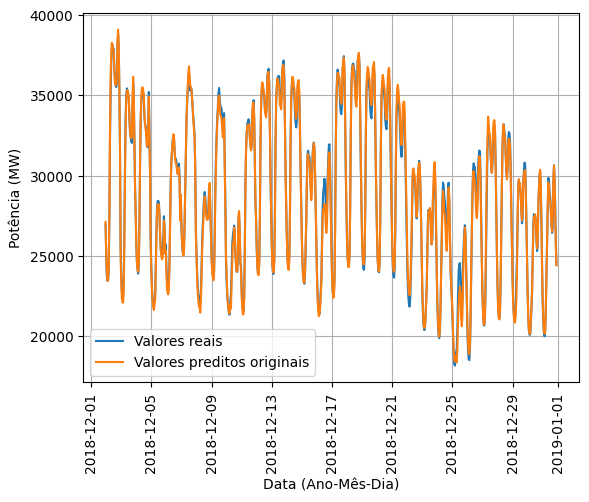

In [6]:
ger_real = df['total load actual']
ger_solar_predito_origem = df['total load forecast']
#ger_real[-240:].plot(label="Valores reais")
#plt.figure(figsize=(10, 6))
plt.plot(ger_real[-24*30:], label='Valores reais')
plt.plot(ger_solar_predito_origem[-24*30:], label='Valores preditos originais')
plt.legend()
plt.grid(True)
plt.ylabel('Potência (MW)')
plt.xlabel('Data (Ano-Mês-Dia)')
plt.xticks(rotation='vertical');

In [7]:
# Pré-processamento
# incluido por VN

# Use o transformador para aplicar a função aos seus dados
# Defina uma função personalizada para calcular o IQR
#series=ger_real.values.reshape(-1, 1)
#def interquartile(series):
#  return iqr(series)

# Crie um transformador de função usando a função personalizada
#transformer = FunctionTransformer(interquartile, validate=False)

# Use o transformador para aplicar a função aos seus dados
#series = transformer.transform(series)
# Os outliers foram eliminados

#dados_transformados = transformer.transform(data)
# Os outliers foram eliminados

#dados_transformados.head()
#plt.plot(data)
#plt.show()
#values1 = df['generation_solar']
#series = values1.values.reshape(-1, 1)

# Calcular o IQR usando a função quantile() do pandas
Q1 = ger_real.quantile(0.25)
Q3 = ger_real.quantile(0.75)
IQR = Q3 - Q1

# Definir limites superior e inferior
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar outliers
ger_real_filt = ger_real[(ger_real >= lower_bound) & (ger_real <= upper_bound)]

# Verificar a quantidade de outliers removidos
outliers_removed = len(ger_real) - len(ger_real_filt)
print("Outliers removidos:", outliers_removed)
ger_real=ger_real_filt
series = ger_real.values.reshape(-1, 1)
series = series.astype('float64')

# Normalizar os dados da série
scaler = MinMaxScaler(feature_range=(0, 1))
series = scaler.fit_transform(series)
ger_real=pd.Series(series.flatten())

Outliers removidos: 36


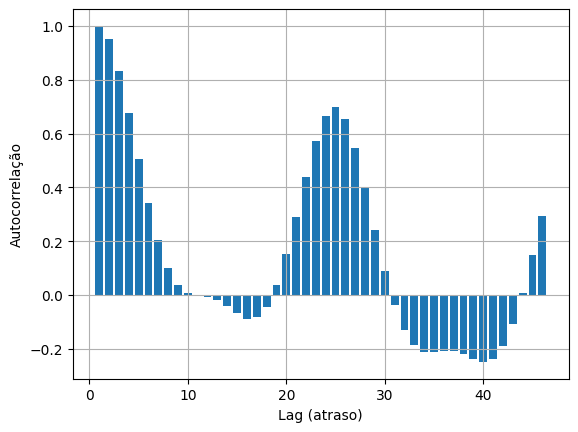

In [8]:
# Correlograma e sazonalidade para determinar tamanho da janela (window size)
# Calcular o correlograma
acf = sm.tsa.acf(ger_real)

# Plotar o correlograma
lags = range(1, len(acf)+1)
#plt.figure(figsize=(10, 6))
plt.bar(lags, acf)
plt.xlabel('Lag (atraso)')
plt.ylabel('Autocorrelação')
#plt.title('Correlograma')
plt.grid(True)
plt.show()

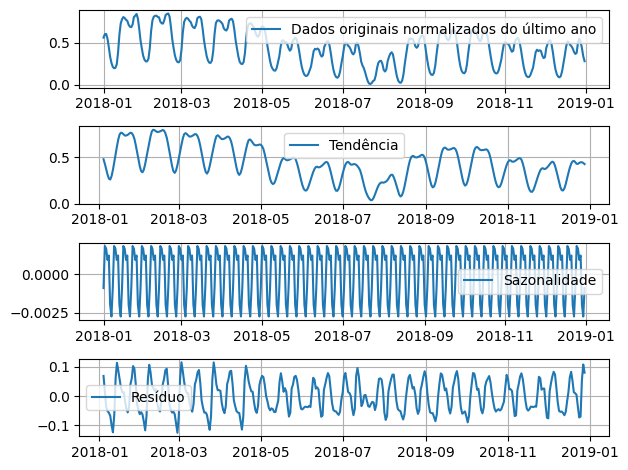

In [9]:
# Definir a série temporal para identificar a sazonalide
# Definir a série temporal
dates = pd.date_range(start='2018-01-01', periods=365, freq='d')
series2 = pd.Series(ger_real.values[-365:], index=dates)

# Converter o índice para um DatetimeIndex
series2.index = pd.DatetimeIndex(series2.index)

# Decompor a série temporal
decomposition = sm.tsa.seasonal_decompose(series2, model='additive')

# Obter as componentes
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plotar as componentes
#plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.grid(True)
plt.plot(series2, label='Dados originais normalizados do último ano')
plt.legend(loc='best')
plt.subplot(412)
plt.grid(True)
plt.plot(trend, label='Tendência')
plt.legend(loc='best')
plt.subplot(413)
plt.grid(True)
plt.plot(seasonal, label='Sazonalidade')
plt.legend(loc='best')
plt.subplot(414)
plt.grid(True)
plt.plot(residual, label='Resíduo')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [10]:
# Tamanho da janela que o correlograma e sazonalidade sugerem: 24h
window_size = 24
from pandas.core import window
def df_to_X_y(df, window_size):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [11]:
X, y = df_to_X_y(ger_real, window_size)
X.shape, y.shape

((35004, 24, 1), (35004,))

In [12]:
X_train, y_train = X[:int(0.8*len(ger_real))], y[:int(0.8*len(ger_real))]
X_val, y_val  = X[int(0.8*len(ger_real)):int(0.9*len(ger_real))], y[int(0.8*len(ger_real)):int(0.9*len(ger_real))]
X_test, y_test = X[int(0.9*len(ger_real)):], y[int(0.9*len(ger_real)):]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((28022, 24, 1), (28022,), (3503, 24, 1), (3503,), (3479, 24, 1), (3479,))

In [13]:
# Autoajuste de hiperparâmetros
# Se usa a função keras_tuner do pacote Keras-Tuner para fazer a busca
# automática de hiperparâmetros para o modelo LSTM. O Keras-Tuner é uma
# biblioteca que permite otimizar automaticamente os hiperparâmetros de um
# modelo de aprendizado de máquina.

# O build_model é uma função que constrói o modelo LSTM com os hiperparâmetros
# ajustáveis. O tuner é criado usando a função RandomSearch, que realiza uma
# busca aleatória de hiperparâmetros. É possível definir os hiperparâmetros
# a serem ajustados usando as classes do Keras-Tuner, como Int para valores
# inteiros e Choice para escolha entre opções.

# A busca de hiperparâmetros é realizada chamando o método search do tuner,
# passando os dados de treinamento e validação, bem como o número de épocas
# para treinamento. Após a busca, você pode obter o melhor modelo encontrado
# usando o método get_best_models.

# Definir a função de construção do modelo
timesteps = window_size
input_dim = 1
def build_model(hp):
    model = keras.Sequential()
    model.add(keras.layers.LSTM(units=hp.Int('units', min_value=32, max_value=512, step=64), # Lo sugerido es step=32
                                dropout=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1),
                                input_shape=(timesteps, input_dim)))
    model.add(keras.layers.Dense(units=1, activation='linear'))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', values=[0.001, 0.01, 0.1])),
                  loss='huber')
    return model

# Definir os hiperparâmetros a serem ajustados
hp = HyperParameters()
hp.Int('units', min_value=32, max_value=512, step=32)
hp.Choice('learning_rate', values=[0.001, 0.01, 0.1])
hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)
# The batch_size is not a parameter of the LSTM layer itself, but rather of the fit method.
#hp.Choice('batch_size', values=[16, 32, 64, 128])  # Adicionando o hiperparâmetro batch_size

# Criar o tuner
tuner = RandomSearch(build_model, objective='val_loss', max_trials=10, hyperparameters=hp)

# Realizar a busca de hiperparâmetros
#tuner.search(x=train_data, y=train_labels, epochs=10, validation_data=(val_data, val_labels))
tuner.search(x=X_train, y=y_train, epochs=5, validation_data=(X_val, y_val))  # Lo sugerido es epochs=10

# Obter o melhor modelo encontrado
best_model = tuner.get_best_models(num_models=1)[0]

best_model.summary()

Trial 10 Complete [00h 19m 52s]
val_loss: 0.7987408638000488

Best val_loss So Far: 0.0011278175516054034
Total elapsed time: 01h 55m 40s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 320)            │       412,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           321 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 412,481 (1.57 MB)

 Trainable params: 412,481 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 320)            │       412,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           321 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 412,481 (1.57 MB)

 Trainable params: 412,481 (1.57 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.losses import Huber
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import InputLayer, LSTM, Dense

#bath=32
#feature=1
#timesteps=24
#X_train_time_major = np.transpose(X_train, (1, 0, 2))
model1 = Sequential()
model1.add(InputLayer((window_size, 1)))
model1.add(LSTM(192, dropout=0.0))#, dropout=0.1,time_major=True, , time_major=True))
# # A camada de dropout=0.3 ajuda a prevenir overfitting
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 192)            │       148,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 150,545 (588.07 KB)

 Trainable params: 150,545 (588.07 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
cp1= ModelCheckpoint('model1/best_model.keras', save_best_only=True)
model1.compile(loss=Huber(), optimizer=Adam(learning_rate=0.01), metrics =[RootMeanSquaredError()])
# função de perda huber: model1.compile(loss=MeanSquaredError(), loss=Huber()) é geralmente utilizada em problemas
# de regressão, onde se deseja uma função de perda menos sensível a outliers.
#model1.compile(loss="mse", optimizer=Adam(learning_rate=0.1), run_eagerly=True)

In [17]:

r=model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp1], batch_size=64)

Epoch 1/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 36s 77ms/step - loss: 0.0343 - root_mean_squared_error: 0.2681 - val_loss: 7.5887e-04 - val_root_mean_squared_error: 0.0390
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 41s 76ms/step - loss: 7.6310e-04 - root_mean_squared_error: 0.0391 - val_loss: 6.1773e-04 - val_root_mean_squared_error: 0.0351
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 41s 76ms/step - loss: 6.2043e-04 - root_mean_squared_error: 0.0352 - val_loss: 7.3285e-04 - val_root_mean_squared_error: 0.0383
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 40s 75ms/step - loss: 5.2364e-04 - root_mean_squared_error: 0.0324 - val_loss: 4.2002e-04 - val_root_mean_squared_error: 0.0290
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 43s 79ms/step - loss: 4.6819e-04 - root_mean_squared_error: 0.0306 - val_loss: 6.1138e-04 - val_root_mean_squared_error: 0.0350
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 40s 77ms/step - loss: 4.5563e-04 - root_mean_squared_error: 0.0301 - val_loss: 3.7825e-04 - val_root_mean_squared_error: 0.0

Text(0, 0.5, 'Loss/RMSE')

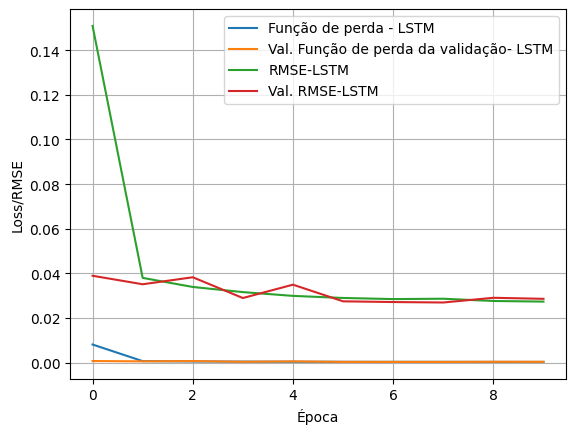

In [29]:
#Plotar a função de perda e RMSE
#plt.figure(figsize=(10, 6))
plt.plot(r.history["loss"], label="Função de perda - LSTM")
plt.plot(r.history["val_loss"], label="Val. Função de perda da validação- LSTM")
plt.plot(r.history["root_mean_squared_error"], label="RMSE-LSTM")
plt.plot(r.history["val_root_mean_squared_error"], label="Val. RMSE-LSTM")
plt.legend()
plt.grid(True)
plt.xlabel('Época')
plt.ylabel('Loss/RMSE') # Removed "(valores normalizados)" from the label

In [19]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/best_model.keras')

In [20]:
train_predictions = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions': train_predictions, 'Actuals':y_train})
#train_results

# Recuperar valores nominais originais
train_results['Train Predictions'] = scaler.inverse_transform(train_results['Train Predictions'].values.reshape(-1, 1)).flatten()
train_results['Actuals'] = scaler.inverse_transform(train_results['Actuals'].values.reshape(-1, 1)).flatten()
#train_results


876/876 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step


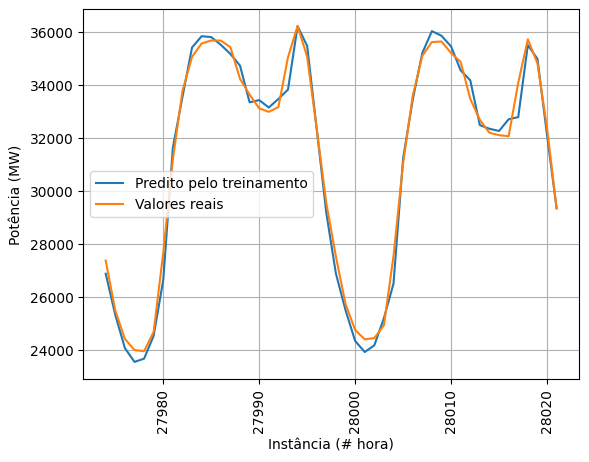

In [21]:
#plt.figure(figsize=(10, 6))
plt.plot(train_results['Train Predictions'][int(0.8*len(ger_real))-48:int(0.8*len(ger_real))], label="Predito pelo treinamento")
plt.plot(train_results['Actuals'][int(0.8*len(ger_real))-48:int(0.8*len(ger_real))], label="Valores reais")
#plt.plot(ger_solar_predito_origem[int(0.8*len(ger_real))-48:int(0.8*len(ger_real))], label='Predição original')
plt.legend()
plt.ylabel('Potência (MW)')
plt.xlabel('Instância (# hora)')
plt.grid(True)
plt.xticks(rotation='vertical');


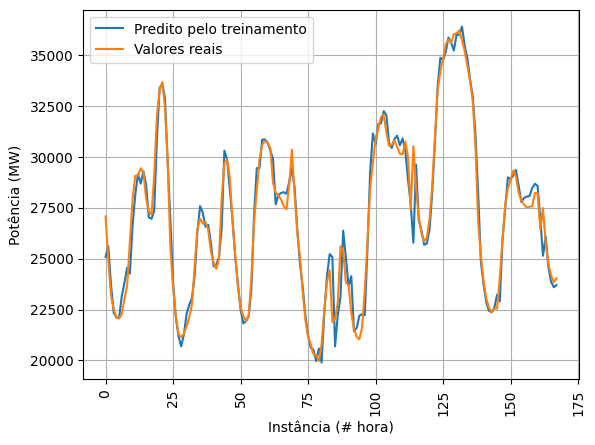

In [22]:
#plt.figure(figsize=(10, 6))
plt.plot(train_results['Train Predictions'][:168], label="Predito pelo treinamento")
plt.plot(train_results['Actuals'][:168], label="Valores reais")
#plt.plot(ger_solar_predito_origem.values[:168], label='Predição original')
plt.legend()
plt.ylabel('Potência (MW)')
plt.xlabel('Instância (# hora)')
plt.grid(True)
plt.xticks(rotation='vertical');

In [23]:
val_predictions = model1.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions': val_predictions, 'Actuals':y_val})
#val_results

# Recuperar valores nominais originais
val_results['Val Predictions'] = scaler.inverse_transform(val_results['Val Predictions'].values.reshape(-1, 1)).flatten()
val_results['Actuals'] = scaler.inverse_transform(val_results['Actuals'].values.reshape(-1, 1)).flatten()
#val_results


110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step


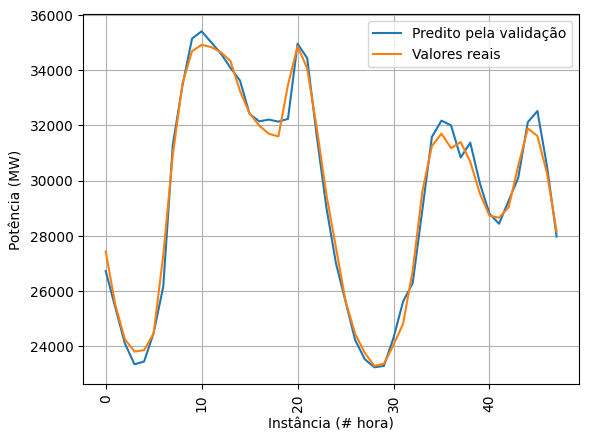

In [24]:
#plt.plot(val_results['Val Predictions'][:48])
#plt.plot(val_results['Actuals'][:48])
#plt.figure(figsize=(10, 6))
plt.plot(val_results['Val Predictions'][:48], label="Predito pela validação")
plt.plot(val_results['Actuals'][:48], label="Valores reais")
#plt.plot(ger_solar_predito_origem.values[:48], label='Predição original')
plt.legend()
plt.ylabel('Potência (MW)')
plt.xlabel('Instância (# hora)')
plt.grid(True)
plt.xticks(rotation='vertical');

In [25]:
test_predictions = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions': test_predictions, 'Actuals':y_test})
#test_results

# Recuperar valores nominais originais
test_results['Test Predictions'] = scaler.inverse_transform(test_results['Test Predictions'].values.reshape(-1, 1)).flatten()
test_results['Actuals'] = scaler.inverse_transform(test_results['Actuals'].values.reshape(-1, 1)).flatten()
#test_results

109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step


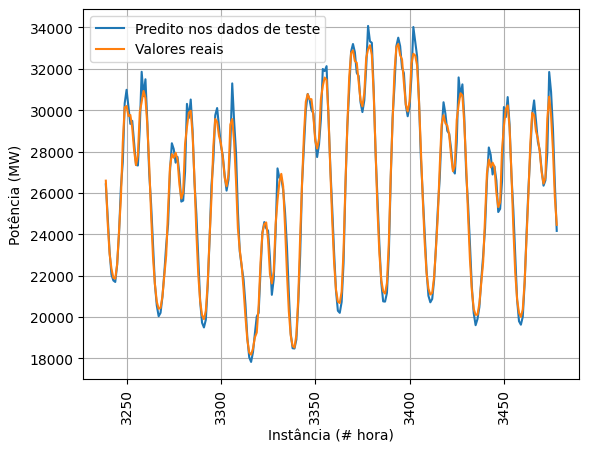

In [26]:
#plt.plot(test_results['Test Predictions'][:48])
#plt.plot(test_results['Actuals'][:48])
#plt.figure(figsize=(10, 6))
plt.plot(test_results['Test Predictions'][-240:], label="Predito nos dados de teste")
plt.plot(test_results['Actuals'][-240:], label="Valores reais")
#plt.plot(ger_solar_predito_origem.values[48:], label='Predição original')
plt.legend()
plt.ylabel('Potência (MW)')
plt.xlabel('Instância (# hora)')
plt.grid(True)
plt.xticks(rotation='vertical');

In [27]:
# Defina a data final dos dados de teste
data_final_teste = pd.to_datetime('2018-12-31')

# Crie as datas de validação e teste
#dates_val = pd.date_range(start='2018-01-01', end=data_final_teste, freq='D')
#dates_test = pd.date_range(start=data_final_teste + pd.DateOffset(days=1), end='2019-12-31', freq='D')
dates_val = pd.date_range(start='2019-01-01', end=data_final_teste, freq='h')
dates_test = pd.date_range(start=data_final_teste + pd.DateOffset(days=1), end='2019-01-31', freq='h')

from copy import deepcopy

recursive_predictions = []
#last_window = deepcopy(X_test[-1])   # Considera o último 1 ponto de dados como preditores
last_window = deepcopy(X_test[-720])  # Considera os últimos 720 pontos de dados como preditores
recursive_dates = np.concatenate([dates_val, dates_test])

for target_date in recursive_dates:
    next_prediction = model1.predict(np.array([last_window])).flatten()
    recursive_predictions.append(next_prediction[0])
    last_window = np.roll(last_window, -1)
    last_window[-1] = next_prediction[0]

# Crie um DataFrame com as previsões
pred_results = pd.DataFrame({'Date': recursive_dates, 'Predictions': recursive_predictions})
print(pred_results)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━

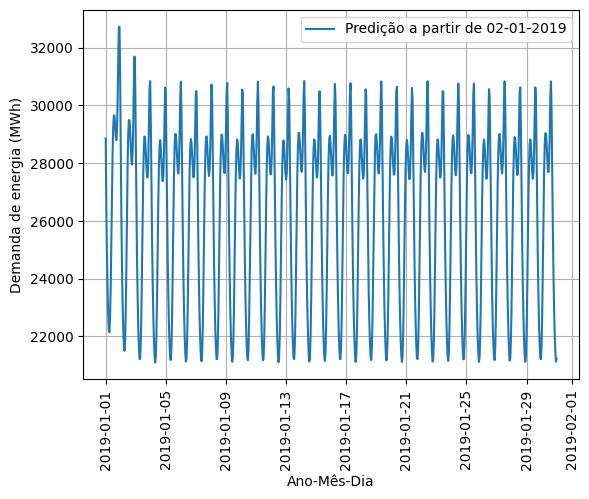

In [28]:
#plt.figure(figsize=(10, 6))
# Recuperar valores nominais originais
pred_results['Predictions'] = scaler.inverse_transform(pred_results['Predictions'].values.reshape(-1, 1)).flatten()

plt.plot(pred_results['Date'], pred_results['Predictions'], label='Predição a partir de 02-01-2019')
plt.xlabel('Ano-Mês-Dia')
plt.xticks(rotation='vertical');
plt.ylabel('Demanda de energia (MWh)')
#plt.title('Valores previstos ao longo do tempo')
plt.legend()
plt.grid(True)
plt.show()


In [30]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate RMSE on the unscaled test results
rmse_mw = np.sqrt(mean_squared_error(test_results['Actuals'], test_results['Test Predictions']))

print(f"RMSE en MW: {rmse_mw:.2f}")

RMSE en MW: 540.98


In [31]:
from sklearn.metrics import mean_squared_error, r2_score

# Calculate MSE on the unscaled test results
mse_mw = mean_squared_error(test_results['Actuals'], test_results['Test Predictions'])

# Calculate R2 on the unscaled test results
r2 = r2_score(test_results['Actuals'], test_results['Test Predictions'])

print(f"MSE en MW^2: {mse_mw:.2f}")
print(f"R2 score: {r2:.4f}")

MSE en MW^2: 292654.11
R2 score: 0.9861
